In [37]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
articles_path = '/Users/kuba/Desktop/PBL/EDA/Articles/articles_01-01-2024_14h39m35s.csv'
trials_path = '/Users/kuba/Desktop/PBL/EDA/Trials/trials_01-01-2024_14h39m35s.csv'

articles = pd.read_csv(articles_path, index_col=0)
trials = pd.read_csv(trials_path, index_col=0)

# Frequency of Word Analysis
Frequency of words analysis in Relevant/not articles (word cloud)

## Articles

In [7]:
articles.summary = articles.summary.astype(str)

### Stemming

In [43]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_stemming(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    words = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_stemming(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_stemming(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package punkt to /Users/kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kuba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


([('cell', 1386),
  ('ms', 1361),
  ('diseas', 1042),
  ('effect', 937),
  ('studi', 883),
  ('sclerosi', 867),
  ('treatment', 828),
  ('multipl', 812),
  ('patient', 801),
  ('activ', 672)],
 [('patient', 431),
  ('diseas', 214),
  ('ms', 205),
  ('studi', 199),
  ('use', 186),
  ('multipl', 181),
  ('sclerosi', 181),
  ('treatment', 142),
  ('clinic', 141),
  ('vaccin', 135)])

### Lemmatization

In [27]:
nltk.download('wordnet')

# Function to preprocess text
def preprocess_lemma(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_lemma(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_lemma(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package wordnet to /Users/kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


([('cell', 1386),
  ('m', 1361),
  ('disease', 1039),
  ('sclerosis', 867),
  ('study', 849),
  ('treatment', 828),
  ('multiple', 812),
  ('patient', 801),
  ('effect', 743),
  ('mouse', 690)],
 [('patient', 431),
  ('disease', 214),
  ('m', 205),
  ('study', 193),
  ('multiple', 181),
  ('sclerosis', 181),
  ('treatment', 142),
  ('cell', 135),
  ('doi', 131),
  ('clinical', 118)])

### Relative Frequencies

In [22]:
def calculate_relative_frequencies(word_counts, total_words):
    return {word: (count / total_words) for word, count in word_counts.items()}

def find_characteristic_keywords(freq_class_1, freq_class_2, threshold=0.01):
    characteristic_keywords = {}
    for word in freq_class_1.keys():
        relative_freq_1 = freq_class_1.get(word, 0)
        relative_freq_2 = freq_class_2.get(word, 0)
        if relative_freq_1 - relative_freq_2 > threshold:
            characteristic_keywords[word] = relative_freq_1
    return characteristic_keywords

# Calculate total words in each class
total_words_relevant = sum(word_freq_relevant.values())
total_words_non_relevant = sum(word_freq_non_relevant.values())

# Calculate relative frequencies
relative_freq_relevant = calculate_relative_frequencies(word_freq_relevant, total_words_relevant)
relative_freq_non_relevant = calculate_relative_frequencies(word_freq_non_relevant, total_words_non_relevant)

# Find characteristic keywords for each class
characteristic_keywords_relevant = find_characteristic_keywords(relative_freq_relevant, relative_freq_non_relevant)
characteristic_keywords_non_relevant = find_characteristic_keywords(relative_freq_non_relevant, relative_freq_relevant)

# Print characteristic keywords
print("Characteristic Keywords for Relevant Articles:", characteristic_keywords_relevant)
print("Characteristic Keywords for Non-Relevant Articles:", characteristic_keywords_non_relevant)


Characteristic Keywords for Relevant Articles: {}
Characteristic Keywords for Non-Relevant Articles: {}


In [23]:
# Function to calculate relative frequency difference and get top characteristic words
def get_top_characteristic_words(freq_class_1, freq_class_2, top_n=10):
    diff_freq = {word: freq_class_1.get(word, 0) - freq_class_2.get(word, 0) for word in freq_class_1.keys()}
    # Sort by difference in frequency
    sorted_diff = sorted(diff_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_diff[:top_n]

# Get the top characteristic words for each class
top_characteristic_words_relevant = get_top_characteristic_words(relative_freq_relevant, relative_freq_non_relevant)
top_characteristic_words_non_relevant = get_top_characteristic_words(relative_freq_non_relevant, relative_freq_relevant)

# Print top characteristic words
print("Top Characteristic Words for Relevant Articles:", top_characteristic_words_relevant)
print("Top Characteristic Words for Non-Relevant Articles:", top_characteristic_words_non_relevant)


Top Characteristic Words for Relevant Articles: [('cell', 0.00820638727262464), ('eae', 0.006317279904879812), ('mouse', 0.005544951701416016), ('m', 0.005138537546424923), ('effect', 0.004615707019701762), ('myelin', 0.0038831866675249783), ('demyelination', 0.003341592213452188), ('oligodendrocyte', 0.0030695549604164646), ('cns', 0.0029615917236657345), ('therapeutic', 0.0029308467000409054)]
Top Characteristic Words for Non-Relevant Articles: [('patient', 0.009485843240797058), ('pwms', 0.002976106855145707), ('nan', 0.002828116658800784), ('age', 0.0026554720146740834), ('infection', 0.002617642489117113), ('vaccination', 0.0023917958076210264), ('case', 0.0023311536142556714), ('vaccine', 0.0021705535760584253), ('people', 0.0017920392121815376), ('care', 0.0017360745048520614)]


### TF-IDF

In [ ]:
# Function to extract top features from TF-IDF for each class
def get_top_tfidf_features(matrix, feature_names, class_index, top_n=10):
    feature_index = matrix[class_index, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [matrix[class_index, x] for x in feature_index])
    sorted_items = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_features = [(feature_names[idx], score) for idx, score in sorted_items[:top_n]]
    return top_features

#### All articles, cumulative

[('set', 0.41256849850351734), ('infect', 0.309426373877638), ('patient', 0.309426373877638), ('case', 0.309426373877638), ('neurolog', 0.309426373877638), ('myeliti', 0.20628424925175867), ('associ', 0.10314212462587934), ('check', 0.10314212462587934), ('antibodi', 0.10314212462587934), ('therefor', 0.10314212462587934)]


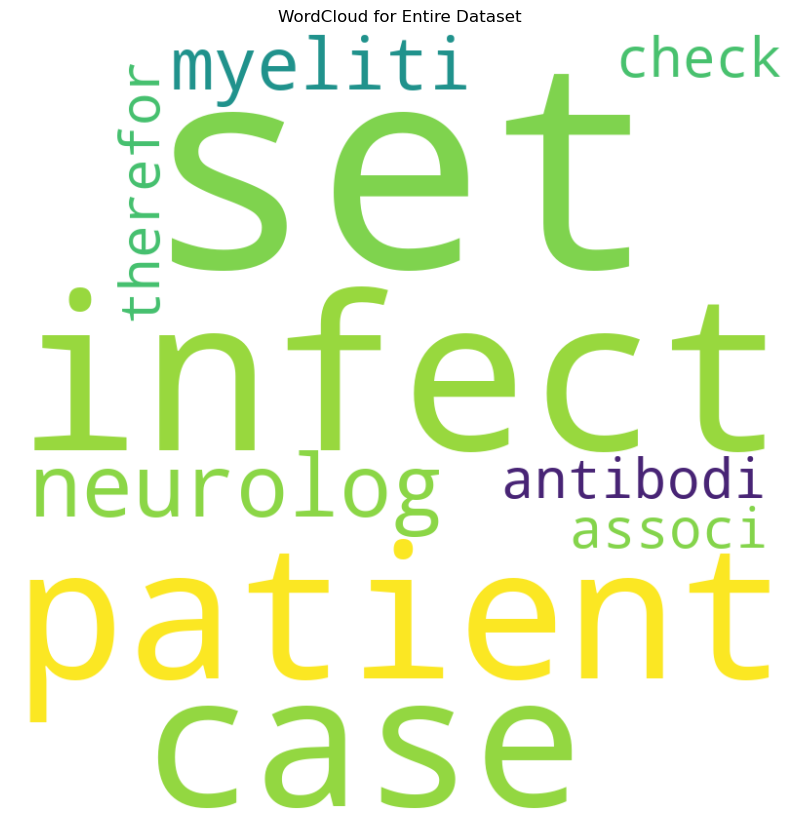

In [49]:
# Process all texts
all_processed_texts = articles[articles.summary.notna()].summary.apply(preprocess_stemming)

# Creating a corpus with all texts
corpus_all_texts = ' '.join(all_processed_texts[0])

# Initialize the TF-IDF Vectorizer, excluding stop words
tfidf_vectorizer_all = TfidfVectorizer(stop_words='english')

# Apply TF-IDF to the entire dataset
tfidf_matrix_all = tfidf_vectorizer_all.fit_transform([corpus_all_texts])

# Extract feature names
feature_names_all = tfidf_vectorizer_all.get_feature_names_out()

# Extract top features from TF-IDF for the entire dataset
top_features_all = get_top_tfidf_features(tfidf_matrix_all, feature_names_all, 0)

# Creating a word cloud for the entire dataset
wordcloud_all = WordCloud(width=800, height=800, background_color='white')
wordcloud_all.generate_from_frequencies(dict(top_features_all))

print(top_features_all)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.title("WordCloud for Entire Dataset")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Relevant/Not Relevant

In [50]:
# Apply preprocessing to each text in the relevant and non-relevant articles
processed_relevant = relevant_articles.apply(preprocess_stemming).to_list()
processed_non_relevant = non_relevant_articles.apply(preprocess_stemming).to_list()

# Concatenate all preprocessed texts in each class
concatenated_relevant = ' '.join(processed_relevant[0])
concatenated_non_relevant = ' '.join(processed_non_relevant[0])

# Creating a corpus with the concatenated texts
corpus = [concatenated_relevant, concatenated_non_relevant]

# Initialize the TF-IDF Vectorizer, excluding stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Apply TF-IDF to the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Extract feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top TF-IDF features for each class
top_features_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 0)
top_features_non_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 1)

top_features_relevant, top_features_non_relevant

([('ms', 0.5256476558706692),
  ('neuriti', 0.3066277992578904),
  ('optic', 0.3066277992578904),
  ('group', 0.2628238279353346),
  ('binocular', 0.2628238279353346),
  ('distanc', 0.21901985661277884),
  ('near', 0.21901985661277884),
  ('control', 0.17521588529022308),
  ('vision', 0.17521588529022308),
  ('vergenc', 0.1314119139676673)],
 [('set', 0.4537666479615949),
  ('infect', 0.34032498597119615),
  ('patient', 0.24214403047635444),
  ('neurolog', 0.24214403047635444),
  ('case', 0.24214403047635444),
  ('myeliti', 0.22688332398079744),
  ('associ', 0.11344166199039872),
  ('check', 0.11344166199039872),
  ('antibodi', 0.11344166199039872),
  ('therefor', 0.11344166199039872)])

### WordClouds

/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_28825/2075061045.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


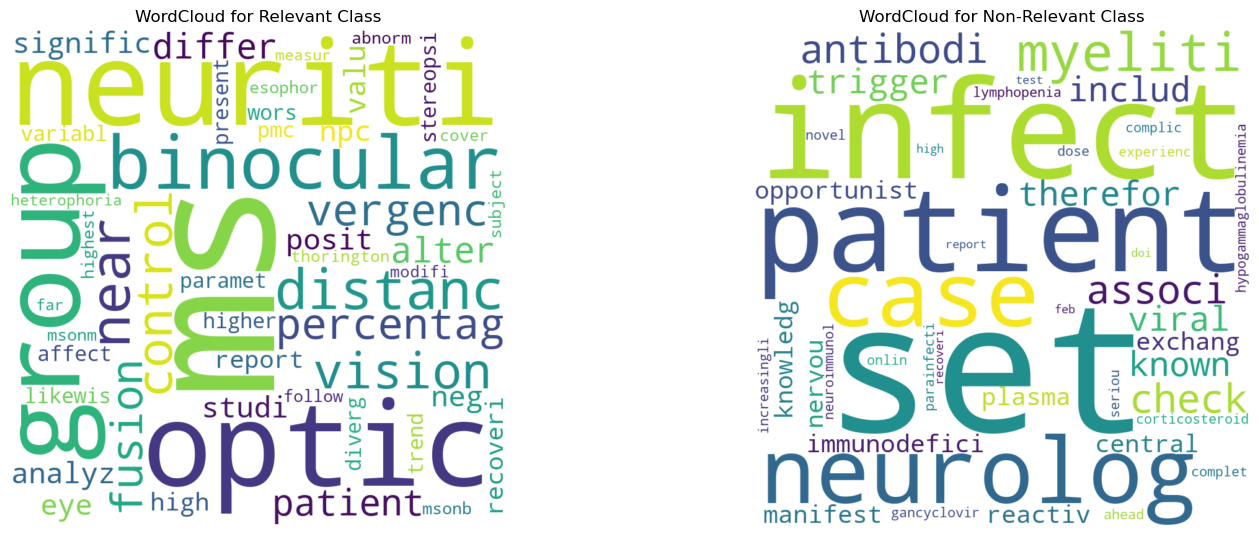

In [45]:
# Recompute top TF-IDF features for each class
top_features_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 0, 50)
top_features_non_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 1, 50)


# Function to create a wordcloud based on TF-IDF scores
def create_wordclouds(tfidf_scores_classes, titles):
    # Setting up subplots with added spacing
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'wspace': 0.5})

    for i, (tfidf_scores, title) in enumerate(zip(tfidf_scores_classes, titles)):
        wordcloud = WordCloud(width=800, height=800, background_color='white')
        # Generating the wordcloud with frequencies
        wordcloud.generate_from_frequencies(dict(tfidf_scores))
        # Plotting the wordcloud in subplot
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout(pad=0)
    plt.show()

# Creating word clouds for both classes in subplots
create_wordclouds([top_features_relevant, top_features_non_relevant], 
                  ["WordCloud for Relevant Class", "WordCloud for Non-Relevant Class"])

### Differential TF-IDF Analysis
a.k.a Class-Specific Keyword Analysis 

In [65]:

# Function to calculate mean TF-IDF score for each word in a class
def mean_tfidf_scores(matrix, feature_names):
    mean_scores = np.array(matrix.mean(axis=0)).flatten()
    return dict(zip(feature_names, mean_scores))

# Separate TF-IDF calculation for each class
tfidf_matrix_relevant = tfidf_vectorizer.fit_transform(processed_relevant[0])
feature_names_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_relevant = mean_tfidf_scores(tfidf_matrix_relevant, feature_names_relevant)

tfidf_matrix_non_relevant = tfidf_vectorizer.fit_transform(processed_non_relevant[0])
feature_names_non_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_non_relevant = mean_tfidf_scores(tfidf_matrix_non_relevant, feature_names_non_relevant)

# Function to find top N differential words
def find_top_differential_words(scores_class1, scores_class2, top_n=10):
    differential_scores = {word: scores_class1.get(word, 0) - scores_class2.get(word, 0) 
                           for word in scores_class1.keys()}
    sorted_differential = sorted(differential_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_differential[:top_n]

# Find top 10 words with high TF-IDF in one class but low in the other
top_differential_words_relevant = find_top_differential_words(mean_scores_relevant, mean_scores_non_relevant)
top_differential_words_non_relevant = find_top_differential_words(mean_scores_non_relevant, mean_scores_relevant)

print("Top Differential Words for Relevant Class:", top_differential_words_relevant)
print("Top Differential Words for Non-Relevant Class:", top_differential_words_non_relevant)




Top Differential Words for Relevant Class: [('ms', 0.0784313725490196), ('neuriti', 0.0457516339869281), ('optic', 0.0457516339869281), ('binocular', 0.0392156862745098), ('group', 0.0392156862745098), ('distanc', 0.032679738562091505), ('near', 0.032679738562091505), ('control', 0.026143790849673203), ('vision', 0.026143790849673203), ('fusion', 0.0196078431372549)]
Top Differential Words for Non-Relevant Class: [('set', 0.06666666666666667), ('infect', 0.05), ('case', 0.043464052287581705), ('neurolog', 0.043464052287581705), ('myeliti', 0.03333333333333333), ('patient', 0.0303921568627451), ('ahead', 0.016666666666666666), ('antibodi', 0.016666666666666666), ('associ', 0.016666666666666666), ('central', 0.016666666666666666)]
